In [296]:
import tensorflow.compat.v2 as tf
from scipy.optimize import minimize
import numpy as np
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

@tf.function
def input_tens(tens):
    tf.print(tens)

def rosen(x): # numpy example of function
    """The Rosenbrock function"""
    return np.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0, axis=0)


@tf.function
def input_(x_tens):
    tf.print(x_tens)

def rosen_tf(x_tens):
    return tf.reduce_sum(100.0 * (x_tens[1:] - x_tens[:-1] ** 2) ** 2 + (1 - x_tens[:-1]) ** 2)


## second_variant ##

def _funct_(x_tens): # takes a tensor type object
    return 0.01 * x_tens[0] ** 2 + x_tens[1] ** 2 - 100.

## define a nonlinear condition functions where is we translate a tensortype

def cons_1(x):
    return x[0] ** 2 + x[1]

def cons_2(x):
    return x[0] ** 2 - x[1]

list_of_nonlinear_functions = [cons_1, cons_2] #

## ________end_________

def _funct_2(x):
    assert(x.shape[0] == 4 and x.shape.__len__() == 1), ('Shape is Wrong!')
    return x[0] ** 2 + x[1] ** 2 + 2 * x[2] ** 2 + x[3] ** 2 -  5 * x[0] - 5 * x[1] - 21 * x[2] + 7 * x[3]

def non_1(x):
    assert(x.shape[0] == 4 and x.shape.__len__() == 1), ('Shape is Wrong!')
    return - x[0] ** 2 - x[1] ** 2 - x[2] ** 2 - x[3] ** 2 - x[0] + x[1] - x[2] + x[3] + 8

def non_2(x):
    assert(x.shape[0] == 4 and x.shape.__len__() == 1) ('Shape is Wrong!')
    return - x[0] ** 2 - 2 * x[1] ** 2 - x[2] ** 2 - 2 * x[3] ** 2 + x[0] + x[3] + 10

def non_3(x):
    assert(x.shape[0] == 4 and x.shape.__len__() == 1) ('Shape is Wrong!')
    return - 2 * x[0] ** 2 - x[1] ** 2 - x[2] ** 2 - 2 * x[0] + x[1] + x[3] +  5

##
#list_of_nonlinear_functions = [non_1, non_2, non_3]

class Nonlinear_constraints(object):

    def __init__(self, x_tensor): # we transfer a x_tensor
        global list_of_nonlinear_functions
        self._stack = []
        ## Here we should write a all nonlinear functions:
        assert (x_tensor.shape.__len__() == 1) , ('shape is not signature: (n, )!')


        self._tensor = x_tensor
        print("tensor: ", x_tensor.__repr__())
        # we work with 2 dims
        for iter_ in range(len(list_of_nonlinear_functions)):
            self._stack.append(list_of_nonlinear_functions[iter_])

        self._s = len(self._stack)

    def wrapper_conditions_(self):
        def _inner_(vars_x) -> float:
            ## Вообще нет смысла обновлять значения
            if(vars_x.shape[0] != self._tensor.shape[0] or vars_x.shape.__len__() != 1):
                assert (False) ('shape is wrong!')

            vars_tf = tf.convert_to_tensor(vars_x)
            stack_return = []
            for iter_ in range(self._s):
                stack_return.append(self._stack[iter_](vars_tf))
            return stack_return # Так или иначе, это стэк list из объектов типа тензоров
        return _inner_


    def jacobian_of_constraints(self):
        global list_of_nonlinear_functions # Тут у нас лежат наши функции нелинейные
        stack_ = []
        with tf.GradientTape(persistent = True) as g:
                g.watch((self._tensor))
                for iter_ in range(self._s):
                    fn_ = list_of_nonlinear_functions[iter_](self._tensor)
                    stack_.append(g.gradient(fn_ , self._tensor))

        return stack_

    def wrapper_jacobian(self):
        def _inner_(vars_x) -> float: # vars_s should be a np.array object
            if(vars_x.shape[0] != self._tensor.shape[0] or vars_x.shape.__len__() != 1):
                assert (False) ('shape is wrong!')
            vars_tf = tf.convert_to_tensor(vars_x)
            self._tensor = vars_tf # we should to change, because  we call jacobian method with automaticly computetion jacobian with self._tensor

            return self.jacobian_of_constraints()

        return _inner_

    def hessian_of_constraints(self):
        global list_of_nonlinear_functions
        matrix_total = []
        for iter_ in range(self._s): # по всем таким функциям делаем проход для рассчёта Hessiana
            matrix_current = []
            with tf.GradientTape(persistent = True) as g: # В рамках одной такой
                g.watch(self._tensor)
                fn_current = list_of_nonlinear_functions[iter_](self._tensor)
                grad_ = g.gradient(fn_current, self._tensor)
                list_current = []
                for jter_ in range(self._tensor.shape[0]):
                    grad_grad_ = g.gradient(grad_[jter_], self._tensor)
                    list_current.append(grad_grad_)

                matrix_current.append(list_current) # На выходе должна быть матрица n*n от размерности

            matrix_total.append(matrix_current)
            matrix_total_tf = tf.convert_to_tensor(matrix_total)

        new_matrix_tf = [] # Чтобы убрать одну размерность!
        for iter_ in range(self._s):
            new_matrix_tf.append(matrix_total_tf[iter_][0])

        return new_matrix_tf # Он возвращает лист с перечисленными тензорами, которые есть Гессианы для каждой нелинейной функции ограничения

    def wrapper_hessians_matrix(self):
        def _inner_(vars_x) -> float:
            if(vars_x.shape[0] != self._tensor.shape[0] or vars_x.shape.__len__() != 1):
                assert (False) ('shape is wrong!')
            vars_tf = tf.convert_to_tensor(vars_x)
            self._tensor = vars_tf

            return self.hessian_of_constraints() # list of tensors hessians
        return _inner_


class function(tf.Module):

    # аттрибут для вывода значений вектора x - как он у нас меняется
    # в процессе иттераций алгоритма scipy

    def compute_gradient_optional(self, functional_obj):
            with tf.GradientTape() as g:
                g.watch(self._tensor)
                res = functional_obj(self._tensor)
                grad_ = g.gradient(res, self._tensor)

            return grad_

    def __init__(self, x_numpy, functional_obj):
        if(x_numpy.shape.__len__() != 1):
            assert (1 != 1) ('shape is not signature : (n, )!')
        else:
            print(" __init__: ", x_numpy, functional_obj, x_numpy.shape, '\n end __init__')
            self._tensor = tf.Variable(x_numpy)
            self._times_call_change = 0
            self._functional_obj = functional_obj # тензорная функция

    def __call__(self, some_parameter = 0): # __call__ function and convert in tensor
        return self._functional_obj(self._tensor) # we call a function object

    def __repr__(self):
        return (self._tensor.__repr__(), self._functional_obj.__repr__())

    def _change(self, new_vector):
        self._times_call_change += 1
        @tf.function
        def assign_(x_new):
            x_new_tensor = tf.convert_to_tensor(x_new)
            if(x_new_tensor.shape != self._tensor.shape):
                assert (1 != 1) ("shape of tensor is not a equal!")
            else:
                self._tensor.assign(x_new_tensor)
        # для вывода текущих значений
        if(self._times_call_change % 4 == 0):
            print('current value of x: ', self._tensor.numpy())

        assign_(new_vector)

    def _wrapper(self): # Обёртка вокруг нашей целевой функции
        def _inner(vars_x) -> np.float32:
            if(vars_x.shape[0] != self._tensor.shape[0]):
                assert (1 != 1) ('Error with different size!: ')
                return None
            else:
                self._change(vars_x) # we change aor vector of x
                return (self.__call__(some_parameter = 0)).numpy()

        return _inner

    def compute_gradient(self):
                with tf.GradientTape() as g:
                    g.watch((self._tensor))
                    f_a = self._functional_obj(self._tensor)
                    grad_ = g.gradient(f_a, self._tensor)

                return grad_

    def wrapper_grad(self):
        def inner_grad(vars_x, *args) -> float: # should be a vector of shape np.float
            if(vars_x.shape[0] != self._tensor.shape[0]):
                assert (1 != 1) ('Error with different size!: ')
                return None
            else:
                self._change(vars_x)
                return self.compute_gradient().numpy()

        return inner_grad

    def compute_hessian(self):
        with tf.GradientTape(persistent = True) as g:
            g.watch(self._tensor)
            f_a = self._functional_obj(self._tensor)
            #f_a = tf.reduce_sum(100.0 * (self._tensor[1:] - self._tensor[:-1] ** 2) ** 2 + (1 - self._tensor[:-1]) ** 2)
            grad_ = g.gradient(f_a, self._tensor)
            list_ = []
            for iter_ in range(self._tensor.shape[0]):
                grad_grad = g.gradient(grad_[iter_], self._tensor)
                list_.append(grad_grad)

            matrix = tf.convert_to_tensor(list_)
        return matrix


    def wrapper_hessian(self):
        def inner_hessian(vars_x, *args) -> float:
            if(vars_x.shape[0] != self._tensor.shape[0]):
                assert (1 != 1) ('Error with different size!: ')
                return None
            else:
                self._change(vars_x)
                return self.compute_hessian().numpy()

        return inner_hessian


x_tens_ = tf.Variable(np.array([1.3, 0.7]))
foo_ = function(x_tens_, rosen_tf)
function_ = foo_._wrapper()
funct_grad = foo_.wrapper_grad()
funct_hessian = foo_.wrapper_hessian()

from scipy.optimize import minimize
x_0 = np.array([1.3 , 0.7])
# Пример поиска минимума тремя разными методам без ограничений
#res_ = minimize(function_, x_0, method = 'nelder-mead', options = {'xtol': 1e-8, 'disp': True})
#print(res_.x)
#res_an_ = minimize(function_, x_0, method = 'BFGS', jac = funct_grad, options = {'disp': False})
#print(res_an_)
#res_another = minimize(function_, x_0, method = 'Newton-CG', jac = funct_grad,hess = funct_hessian,options = {'xtol' : 1e-8, 'disp': True})
#print(res_another)
# Пример задачи минимизации уже с ограничениями как в статье на scipy.optimize


x_ = tf.Variable(np.full((2, ), 2.), dtype = tf.float64)
nonlinear_constraints = Nonlinear_constraints(x_) # create a object Nonlinear

def wr_cons_f(nonlinear_constraints):
    def cons_f(x):
        wrapper_obj = nonlinear_constraints.wrapper_conditions_()
        wrapper_obj = list(map(lambda x: x.numpy(), wrapper_obj(x)))
        return wrapper_obj
    return cons_f

def wr_cons_J(nonlinear_constraints):
    def cons_J(x):
        funct_obj = nonlinear_constraints.wrapper_jacobian()
        funct_obj = list(map(lambda x: list(x.numpy()), funct_obj(x)))
        return funct_obj
    return cons_J

def wr_cons_H(nonlinear_constraints):
    def cons_H(x, v): # x - np.array() v - np.array() also
        if(nonlinear_constraints._s != v.shape[0] or v.shape.__len__() != 1):
            assert(False) ('shape of v vector is wrong!')

        wrapper_obj = nonlinear_constraints.wrapper_hessians_matrix()
        wrapper_obj = wrapper_obj(x) # _inner_(vars_x) -> float: по факту тут вычисленный list с tensors hessians
        total_ = 0 # H(x, v) как в статье
        for iter_ in range(nonlinear_constraints._s):
            total_ += v[iter_] * wrapper_obj[iter_].numpy()

        return total_
    return cons_H

bounds = Bounds([0, -0.5], [1.0, 2.0])
linear_constraint = LinearConstraint([[1, 2], [2, 1]], [-np.inf, 1],
                                     [1,1])
nonlinear_constraints_ = NonlinearConstraint(wr_cons_f(nonlinear_constraints), -np.inf, 1,
                                             jac = wr_cons_J(nonlinear_constraints), hess = wr_cons_H(nonlinear_constraints))

res_constraints_ = minimize(function_, x_0, method = 'trust-constr', jac = funct_grad,
               hess = funct_hessian,
               constraints = [linear_constraint, nonlinear_constraints_],
               options = {'verbose': 1}, bounds = bounds)
print(res_constraints_.x)

bounds_2 = Bounds([2., 50.], [-50., 50.])
linear_constraint_2 = LinearConstraint([10, -1], 10, +np.inf)

x_tens_2  = tf.Variable(np.array([-1, -1], dtype = np.float64))
foo_2 = function(x_tens_2, _funct_)
function_2 = foo_2._wrapper()
funct_grad_2 = foo_2.wrapper_grad()
funct_hessian_2 = foo_2.wrapper_hessian()

x_0_2 = x_tens_2.numpy()

#res_constraints_2 = minimize(function_2, x_0_2, method = 'trust-constr',
#                            jac = funct_grad_2, hess = funct_hessian_2,
#                            constraints = [linear_constraint_2],
#                            options = {'verbose': 1}, bounds = bounds_2)

#print(res_constraints_2.x)
#foo_2._functional_obj(tf.constant(np.array([2, 0], dtype = np.float64)))


rosen_tf(tf.constant([2.,4.], dtype = tf.float64))

W0411 19:28:37.237143 139699871221568 backprop.py:995] Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
W0411 19:28:37.238929 139699871221568 backprop.py:995] Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
W0411 19:28:37.243899 139699871221568 backprop.py:995] Calling GradientTape.gradient on a persistent tape inside its context is signif

 __init__:  <tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([1.3, 0.7])> <function rosen_tf at 0x7f0d07ee80d0> (2,) 
 end __init__
tensor:  <tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([2., 2.])>
current value of x:  [1.3 0.7]
current value of x:  [0.4218575  0.04762861]
current value of x:  [0.42750931 0.14498137]
current value of x:  [0.41673545 0.16652911]
current value of x:  [0.41507145 0.1698571 ]
current value of x:  [0.41496936 0.17006128]
current value of x:  [0.41494931 0.17010138]
`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 10, CG iterations: 9, optimality: 2.99e-09, constraint violation: 0.00e+00, execution time: 0.23 s.
[0.41494531 0.17010937]
 __init__:  <tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([-1., -1.])> <function _funct_ at 0x7f0d07bf7950> (2,) 
 end __init__


<tf.Tensor: shape=(), dtype=float64, numpy=1.0>




\begin{equation}
\begin{gathered}
\min\limits_{ w } w^{T}\Sigma w \\
\sum_{i = 1}^{n} r_{i}w_{i}  \geq q  \\
\sum_{i = 1}^{n} w_{i} = 1 
\end{gathered}
\end{equation}

Можно, также, помимо линейных ограничений ввести ещё и bounds conditions. Разрешив нашим весовым параметрам быть только положительными! 
\begin{equation}
w_{i} \geq 0 , \;\;\;\; i = 1..n
\end{equation}


In [389]:
import quandl
import pandas as pd
#############
key_const = 'f8nzs159xkB-_NJg4LCB'
dict_of_securities = ['CNP', 'F', 'WMT', 'GE', 'TSLA'] #by default
quandl.ApiConfig.api_key = key_const
trading_days = 252
#############


## Надо его адаптировать под класс функций, чтобы формат записи был один и тот же ## 
## У нас для создания объекта класса function необходим массив строчный типа tf.Variable
## Ф также функция с сигнатурой foo(tensor_type_obj) : -> tensor_type_obj для нашего функционала
## Пока без ограничений при этом мы передадим в наш класс только initial_value для дальнейшего изменения

class Markovitz_theory(object):
    global key_const # my key for access to data
    global dict_of_securities
    
    def __init__(self):
        
        self.flag = False # По сути детектирует то, что пока мы не вызвали метод _initial_model_param_
        self.level_risks = None
        self.weights = None
        self.cov_daily_tf = None
        self.returns_annual_tf = None
        
        self.data = quandl.get_table('WIKI/PRICES', ticker = dict_of_securities,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2016-12-31' }, paginate = True)
        self.data = self.data.set_index('date')
        self.data = self.data.pivot(columns = 'ticker')
    
    def _initial_model_param_(self):
        if self.flag == False:
            
            num_of_securities = dict_of_securities.__len__()
            daily_returns_data = self.data.pct_change()
            
            self.returns_annual_tf = tf.constant((daily_returns_data.mean() * trading_days)[:, np.newaxis], dtype = tf.float64) # maybe should be a dtype = tf.float32/tf.float64
            self.cov_daily_tf = tf.constant((daily_returns_data.cov() * trading_days).values, dtype = tf.float64) # matrix of covariation between different columns
            
            #cov_annual = cov_daily.mean() * trading_days # Это пока не используется
            ## initial weigthts ## По простому это наши неизвестные, по которым у нас распределены доходы
            ##  он даёт только положительные веса, поэтму  в принципе стоит добавить ограничения
            weights = np.random.random(num_of_securities) # Мы тут выбираем равномерное распределение [0,1]
            
            self.weights = tf.Variable((weights / np.sum(weights))[:, np.newaxis], dtype = tf.float64, name = 'weights')      
            self.flag = True
            print("initial_weights w: {!s}".format(self.weights.numpy())) # call only one time
    
    def _Markovitz_functionals_(self): # weights should be a tensor для реализации functionS 
        ### Здесь мы проинтициализируем параметры модели Марковица для определения функционала(!уровня риска!) - мы его минимизируем
        if(self.flag == False): # Я не задад параметры и начальные веса модели, то мы их инициализируем 
            self._initial_model_param_()
        ### тут мы обменяем два тензорных объекта self.weights <-> weights_tf ###
        ### weights_tf - should be a shape (num, ) -> ###
        return tf.sqrt(tf.matmul(tf.transpose(self.weights), tf.matmul(self.cov_daily_tf, self.weights)))[0][0]
    
    
    def __str__(self):
        return "r: \n {!s} \n W:\n {!s} \n COV(r_i, r_j):\n {!s} \n".format(self.returns_annual_tf.numpy(), self.weights.numpy(),
                                                                 self.cov_daily_tf.numpy())
    # наша модель включает ограничения только типа равенств и неравенств линейного типа. Данная функция будет принимать нижнею
    # Границу наших рисков и минимизировать deviation
    def _linear_constraints_(self, Q):
        linear_constraints = LinearConstraint([list(self.returns_annual_tf.numpy()[:, 0]), # вроде в виде list мы должны засунуть
                                               list(np.ones(self.returns_annual_tf.shape[0]))],
                                               [Q, 1.], [np.inf, 1.])
        return linear_constraints
    def plot_a_convex_field(self):
        if(self.flag == False):
            self._initial_model_param_()
        
        port_returns = []
        port_volatility = []
        stock_weights = []
        
        num_asset = dict_of_securities.__len__()# for five a securities
        num_portfolios = 50000 # number of generations of portfolios
        
        for single_portfolio in range(num_portfolios):
            weights = np.random.random(num_asset)
            weights = weights / np.sum(weights)
            weights = weights[:, np.newaxis]
            returns = np.dot(weights.T, self.returns_annual_tf.numpy())[0][0]
            volatility  = np.sqrt(np.dot(weights.T, np.dot(self.cov_daily_tf.numpy(), weights))) # В статьке было cov_annual
            port_returns.append(returns)
            port_volatility.append(volatility[0][0])
            stock_weights.append(weights)
            
        portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}    

        for counter, name_access in enumerate(dict_of_securities):
            portfolio[name_access + str('weights')] = [Weights[counter] for Weights in stock_weights]
        ## Create a our data set for visualization ##
        df = pd.DataFrame(portfolio)
        column_name = ['Returns', 'Volatility'] + [stock + 'weights' for stock in dict_of_securities]
        df = df[column_name]
        print(df.head())
        plt.style.use('seaborn')
        df.plot.scatter(x = 'Volatility', y = 'Returns', figsize = (10, 8), grid = True)
        # после опитимизации мы можем для текущего уровня построить точку нашего удовлетворяющего портфеля
        plt.plot(np.linspace(0.13, 0.37, 50), [self.level_risks for a in range(50)],'r--' )
        plt.scatter(self._volatility_().numpy(), self.__return_total__().numpy(), c = 'g')
        plt.xlabel('Volatility (Std. Deviation)')
        plt.ylabel('Expected Returns')
        plt.title('Efficient Frontier')
        plt.show()
        
    def _bounds_(self):
        bounds = Bounds([0.0] * self.weights.shape[0], [np.inf] * self.weights.shape[0])
        return bounds
    
    def __return_total__(self):
        return tf.matmul(tf.transpose(self.weights), self.returns_annual_tf)[0][0]
    
    def _volatility_(self):
        return tf.sqrt(tf.matmul(tf.transpose(self.weights), tf.matmul(self.cov_daily_tf, self.weights)))[0][0]
    
def _wrapper_marcovitz(model_mark):
    cov_matrix = model_mark.cov_daily_tf
    def _Marcovitz_risks(weights_tf):
        if(weights_tf.shape.__len__() != 2):
            weights_tf = weights_tf[:, np.newaxis]

        return tf.matmul(tf.transpose(weights_tf), tf.matmul(cov_matrix, weights_tf))[0][0]
    return _Marcovitz_risks


In [390]:
### Создание объекта модели и расчет начальных весов и параметров портфеля Марковица на основе данных, полученных из Quandl ###
model_ = Markovitz_theory() # создаём объект, который содержит наш функционал и параметры модели
model_._initial_model_param_() # Инициализация начальных параметров, делается только один раз  

initial_weights w: [[0.34259205]
 [0.08791695]
 [0.44241048]
 [0.05128434]
 [0.07579619]]


In [391]:
functionals_Markovitz = _wrapper_marcovitz(model_)
functionals_Markovitz(model_.weights[:,0])

<tf.Tensor: shape=(), dtype=float64, numpy=0.023136174955032087>

In [392]:
foo_mark = model_._Markovitz_functionals_
def __wrapper__(param):
    global foo_

__wrapper__(model_._Markovitz_functionals_)

In [393]:
# созданы просто для проверки подсчёта градиентов, что вообще наш метод способен подсчитать тот функционал
def rigth_gradient():
    global model_
    with tf.GradientTape(persistent = True) as g:
        g.watch((model_.weights))
        functional = model_._Markovitz_functionals_()
        grad_ = g.gradient(functional, model_.weights)

def grad_numpy(model):
    return [2 * np.dot(model.cov_daily_tf.numpy(), model.weights.numpy())[ind_] \
            for ind_ in range(model.weights.shape[0])]

### созданеи объектов типа linear_const и bounds ###
Q = 0.15 # Риск, допустимый, который нас устраивает 
model_.level_risks = Q
linear_const_mark = model_._linear_constraints_(Q) # create a oblect LinearConstraints
bounds_mark = model_._bounds_() # create a object of bounds condition
W_0 = model_.weights.numpy() # tensor object Variable мы его в numpy переводим(мы его передаём в сам minimize)

functionals_Markovitz = _wrapper_marcovitz(model_) # return a functional_obj
### Повторяем как было выше для обычной минимизации ###
foo_markovitz_obj = function(W_0[:, 0], functionals_Markovitz) # Так как в классе модели марковица вектор представлен в виде (num, 1) -> (num, ) 
function_mark = foo_markovitz_obj._wrapper()
function_mark_grad = foo_markovitz_obj.wrapper_grad()
function_mark_hess = foo_markovitz_obj.wrapper_hessian()
### Конец создания необходимых функциональных объектов ###

### Вызываем решатель ###
res_Markovitz = minimize(function_mark, W_0[:, 0], method = 'trust-constr', jac = function_mark_grad,
                        hess = function_mark_hess, constraints = [linear_const_mark],
                        options = {'verbose': 1}, bounds = bounds_mark)
print("_output_: ", res_Markovitz, '_end_\n')
print('\n answer: ', res_Markovitz.x)


### change our new parameter ###
model_.weights = tf.Variable(res_Markovitz.x[:, np.newaxis])
model_.weights

model_.__return_total__(), model_._volatility_()

 __init__:  [0.34259205 0.08791695 0.44241048 0.05128434 0.07579619] <function _wrapper_marcovitz.<locals>._Marcovitz_risks at 0x7f0d072ee488> (5,) 
 end __init__
current value of x:  [0.34259205 0.08791695 0.44241048 0.05128434 0.07579619]
current value of x:  [0.3545282  0.17922229 0.38676591 0.18403448 0.23703313]
current value of x:  [0.26053198 0.14623936 0.27247236 0.23890881 0.16966267]
current value of x:  [0.25235516 0.14263294 0.25910152 0.28446178 0.16174475]
current value of x:  [0.25327852 0.07494878 0.26025497 0.34765793 0.09368348]
current value of x:  [0.18009067 0.03140854 0.19244054 0.56815089 0.03222973]
current value of x:  [0.18451583 0.02789048 0.19761941 0.5585774  0.03139687]
current value of x:  [0.18848479 0.00271046 0.30658464 0.49956181 0.0026583 ]
current value of x:  [0.2092073  0.00099714 0.29026874 0.4978665  0.00166032]
current value of x:  [2.09912797e-01 3.07691737e-04 2.94228595e-01 4.95416555e-01
 1.34360980e-04]
current value of x:  [2.09713855e-01

(<tf.Tensor: shape=(), dtype=float64, numpy=0.15000188863544808>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.24594325846862497>)

    Returns  Volatility              CNPweights               Fweights  \
0  0.054131    0.141178   [0.22390024354908794]  [0.14936105593455085]   
1  0.031839    0.157086   [0.06976692064838066]   [0.3369494410308177]   
2  0.070516    0.147759   [0.16536771010813417]  [0.09104003029687843]   
3  0.113911    0.186411   [0.34306266766267285]   [0.0202960544325064]   
4  0.032061    0.153307  [0.010032022697096164]   [0.3261519065060935]   

              WMTweights              GEweights            TSLAweights  
0  [0.24271594970194746]  [0.05558554632773719]   [0.3284372044866765]  
1  [0.05013147902252466]  [0.11362744232501845]   [0.4295247169732585]  
2   [0.3209062305947081]  [0.12253770422182277]   [0.3001483247784566]  
3  [0.21687308489094118]  [0.29807886660637756]  [0.12168932640750202]  
4  [0.19568322384690756]  [0.07316307739751525]  [0.39496976955238766]  


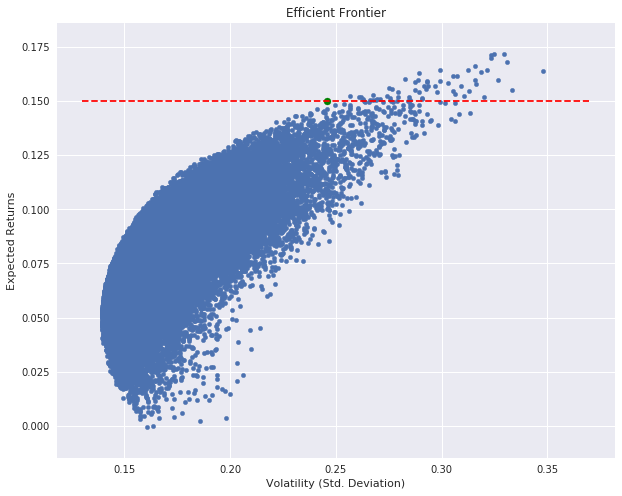

In [394]:
model_.plot_a_convex_field()

In [395]:
def grad_(weight_tf):
    with tf.GradientTape() as g:
        g.watch((weight_tf))
        fun = functionals_Markovitz(weight_tf)
        grad_ = g.gradient(fun, weight_tf)
        return grad_
    
    
grad_(model_.weights)
grad_numpy(model_), grad_(model_.weights)

class dop_(object):
    
    def __init__(self, vec_numpy, _funcion_):
        self.tens = tf.Variable(vec_numpy)
        self._function_ = _funcion_

    def _grad_(self):
        with tf.GradientTape() as g:
            g.watch((self.tens))
            f = self._function_(self.tens)
            grad_ = g.gradient(f, self.tens)
        return grad_
    
cov_matrix_ = model_.cov_daily_tf
    
def simple_realization(weight):
    global cov_matrix_
    weight = weight[:, np.newaxis]
    return tf.sqrt(tf.matmul(tf.transpose(weight), tf.matmul(cov_matrix_, weight)))[0][0]

cls_ = dop_(model_.weights[:,0].numpy(), simple_realization)
cls_._grad_()

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.08903729, 0.09735956, 0.09878591, 0.40038702, 0.04767748])>

In [324]:
class A():
    def __init__(self):
        self.value = 2.
    
    def _foo_(self, param):
        self.value = param
        print(self.value, '\n')
        return self.value ** 2

a = A()
funct_ = a._foo_
funct_(3)
a.value
def wrap(arg_1):
    arg_inner = arg_1 * 2
    def _foo_(arg_2):
        print( arg_inner )
        return arg_1 + arg_2 + arg_inner
    return _foo_

foo_copy_ = wrap(arg_1 = 1.)


def wrapper_new_(funct_obj):
    return funct_obj(1)

wrapper_new_(foo_copy_)
foo_copy_(1.)



3 

2.0
2.0


4.0